# Reading ENVI_MET files

Let's take a look at reading the output of the ENVI_MET microclimate model, as described at http://www.envi-met.net/hg2e/doku.php?id=filereference:edx_edi

Outputs consist of pairs of files - `.EDX` xml file containining metadata for a single output time, and `.EDT` files containing binary data.

## Reading metadata

Let's start out with the `.EDX` metadata. XML is pretty easy to read in python - https://docs.python.org/3.6/library/xml.etree.elementtree.html

Note we need to define the file encoding, since it's using special characters (degrees symbol)

In [1]:
import xml.etree.ElementTree as ET

In [5]:
parser = ET.XMLParser(encoding='ISO-8859-1')
meta = ET.parse('UrbanLayout_noIVS_AT_23.00.01 23.07.2013.EDX', parser=parser).getroot()

Specific XML nodes can be accessed using `.find()`, which takes a path. Get the text inside the node with `.text`

A bit of simple text processing gets a list of variable names

In [21]:
variable_names = meta.find('variables/name_variables').text.strip().split(',')
variable_names

['Objects ( )',
 'Flow u (m/s)',
 'Flow v (m/s)',
 'Flow w (m/s)',
 'Wind Speed (m/s)',
 'Wind Speed Change (%)',
 'Wind Direction (deg)',
 'Pressure Perturbation (Diff)',
 'Air Temperature (°C)',
 'Air Temperature Delta (K)',
 'Air Temperature Change (K/h)',
 'Spec. Humidity (g/kg)',
 'Relative Humidity (%)',
 'TKE (m²/m³)',
 'Dissipation (m³/m³)',
 'Vertical Exchange Coef. Impuls (m²/s)',
 'Horizontal Exchange Coef. Impuls (m²/s)',
 'Vegetation LAD (m²/m³)',
 'Direct Sw Radiation (W/m²)',
 'Diffuse Sw Radiation (W/m²)',
 'Reflected Sw Radiation (W/m²)',
 'Temperature Flux (K*m/s)',
 'Vapour Flux (g/kg*m/s)',
 'Water on Leafes (g/m²)',
 'Leaf Temperature (°C)',
 'Local Mixing Length (m)',
 'Mean Radiant Temp. (°C)',
 'TKE normalised 1D ( )',
 'Dissipation normalised 1D ( )',
 'Km normalised 1D ( )',
 'TKE Mechanical Turbulence Prod. ( )',
 'Stomata Resistance (s/m)',
 'CO2 (mg/m3)',
 'CO2 (ppm)',
 'Plant CO2 Flux (mg/m²s)',
 'Div Rlw Temp change (K/h)',
 'Building Number ()']

Get the array dimensions - we need to manually convert these to numbers with `int()`

In [20]:
nr_xdata = int(meta.find('datadescription/nr_xdata').text)
nr_ydata = int(meta.find('datadescription/nr_ydata').text)
nr_zdata = int(meta.find('datadescription/nr_zdata').text)
nr_ndata = int(meta.find('variables/Data_per_variable').text)

## Reading binary files

Now we have the metadata, let's read the actual data. This is stored as a binary file of little-endian floating point numbers, which can be read with numpy

In [23]:
import numpy
data = numpy.fromfile('UrbanLayout_noIVS_AT_23.00.01 23.07.2013.EDT','<f4')

Sanity check - did we read the expected number of values?

In [90]:
len(data) == len(variable_names)*nr_xdata*nr_ydata*nr_zdata*nr_ndata

True

Currently the data is just a 1d array. `.reshape()` it to the proper shape, as defined in the format documentation

In [89]:
cube = data.reshape((len(variable_names), nr_zdata, nr_ydata, nr_xdata, nr_ndata))
cube.shape

(37, 24, 100, 100, 1)

Another sanity check - field 8 is supposed to be temperature, are the values reasonable? Make sure the axes aren't flipped

22.4075 23.7675 30.7352


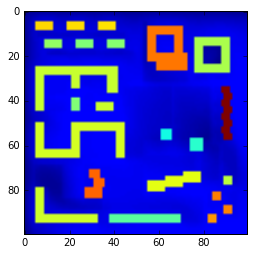

In [93]:
t = cube[8,:,:,:,:]

%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(t[0,:,:,0])
print(t.min(), t.mean(), t.max())

The `xarray` library is similar to Pandas, but for multiple dimensions. Create a dataset, so that we can access variables by their names rather than the index:

In [94]:
import xarray

ds = xarray.Dataset({name: (['x','y','z','n'], cube[idx,:,:,:,:]) for idx, name in enumerate(variable_names)})
ds

<xarray.Dataset>
Dimensions:                                  (n: 1, x: 24, y: 100, z: 100)
Dimensions without coordinates: n, x, y, z
Data variables:
    Objects ( )                              (x, y, z, n) float32 0.0 0.0 ...
    Flow u (m/s)                             (x, y, z, n) float32 0.488468 ...
    Flow v (m/s)                             (x, y, z, n) float32 0.512861 ...
    Flow w (m/s)                             (x, y, z, n) float32 0.00120439 ...
    Wind Speed (m/s)                         (x, y, z, n) float32 0.708258 ...
    Wind Speed Change (%)                    (x, y, z, n) float32 102.205 ...
    Wind Direction (deg)                     (x, y, z, n) float32 223.604 ...
    Pressure Perturbation (Diff)             (x, y, z, n) float32 2.91062 ...
    Air Temperature (°C)                     (x, y, z, n) float32 22.4075 ...
    Air Temperature Delta (K)                (x, y, z, n) float32 -0.100772 ...
    Air Temperature Change (K/h)             (x, y, z, n) flo

## General read function

Here's a function that ties all of this together. It also adds a time value from the metadata. Similarly, if the x and y co-ordinates are known they can be added to the `coords` argument of `xarray.Dataset`.

In [95]:
import os
import pandas
import numpy
import xarray
import xml.etree.ElementTree as ET

def open_edx(filename):
    """
    Open a EDX/EDT dataset
    
    Returns an xarray dataset
    """
    # Parse the metadata file
    parser = ET.XMLParser(encoding='ISO-8859-1')
    meta = ET.parse(filename, parser=parser).getroot()
    
    variable_names = meta.find('variables/name_variables').text.strip().split(',')
    
    nr_xdata = int(meta.find('datadescription/nr_xdata').text)
    nr_ydata = int(meta.find('datadescription/nr_ydata').text)
    nr_zdata = int(meta.find('datadescription/nr_zdata').text)
    nr_ndata = int(meta.find('variables/Data_per_variable').text)
    
    date = meta.find('modeldescription/simulation_date').text.strip()
    time = meta.find('modeldescription/simulation_time').text.strip()
    
    # Get the time
    t = pandas.to_datetime(date+' '+time, format='%d.%m.%Y %H:%M:%S')
    
    # Read the data file
    data = numpy.fromfile(os.path.splitext(filename)[0]+'.EDT','<f4')
    cube = data.reshape((len(variable_names), nr_zdata, nr_ydata, nr_xdata, nr_ndata, 1))
    
    # Create a dataset
    dataset = xarray.Dataset({name: (['z','y','x','n','time'], cube[idx,:,:,:,:])
                              for idx, name in enumerate(variable_names)},
                            coords={'time': [t]},
                            )
    return dataset

## Processing data

Individual files can be joined along the time dimension using `xarray.concat()`

In [96]:
ds1 = open_edx('UrbanLayout_noIVS_AT_22.00.01 23.07.2013.EDX')
ds2 = open_edx('UrbanLayout_noIVS_AT_23.00.01 23.07.2013.EDX')
ds = xarray.concat([ds1,ds2], dim='time')
ds.time

<xarray.DataArray 'time' (time: 2)>
array(['2013-07-23T22:00:01.000000000', '2013-07-23T23:00:01.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2013-07-23T22:00:01 2013-07-23T23:00:01

To get a Pandas dataframe, narrow down to one dimension using `.isel()` then call `.to_dataframe()`

In [87]:
ds.isel(x=50,y=7,z=0,n=0).to_dataframe()

,Objects ( ),Flow u (m/s),Flow v (m/s),Flow w (m/s),Wind Speed (m/s),Wind Speed Change (%),Wind Direction (deg),Pressure Perturbation (Diff),Air Temperature (°C),Air Temperature Delta (K),...,TKE normalised 1D ( ),Dissipation normalised 1D ( ),Km normalised 1D ( ),TKE Mechanical Turbulence Prod. ( ),Stomata Resistance (s/m),CO2 (mg/m3),CO2 (ppm),Plant CO2 Flux (mg/m²s),Div Rlw Temp change (K/h),Building Number ()
time,,,,,,,,,,,,,,,,,,,,,
2013-07-23 22:00:01,0.0,0.425640,0.646294,0.003525,0.773872,109.836174,213.368301,1.480833,23.992090,0.454916,...,18.302456,11.21650,29.86492,0.198397,-999.0,646.296021,359.616669,0.0,9.568902,-999.0
2013-07-23 23:00:01,0.0,0.425784,0.649482,0.003574,0.776616,112.069305,213.247787,1.546655,23.017899,0.509627,...,18.987762,11.88013,30.34774,0.197656,-999.0,646.296021,358.368988,0.0,8.379407,-999.0


Or stay in xarray and use its plotting tools

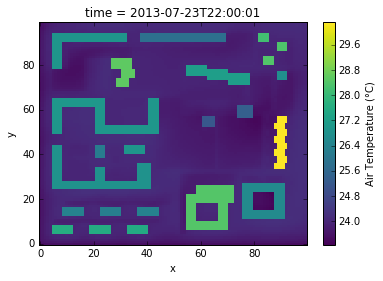

In [98]:
ds['Air Temperature (°C)'].isel(z=0,n=0,time=0).plot()